Набор данных ORGANICS содержит 13 переменных и более 22000 наблюдений.

Описание: В супермаркете действует программа лояльности клиентов. В качестве плана для первоначального стимулирования покупок всем участникам программы лояльности были предложены купоны на покупку органических продуктов. Затем были собраны данные о том, купили ли эти клиенты какой-либо из органических продуктов.

Цель: Исследовать модель для предсказания влияний купонов на покупку товара.

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import pydot

from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import (RandomOverSampler,
                                    SMOTE,
                                    ADASYN)
from imblearn.under_sampling import NearMiss

plt.style.use('ggplot')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# подключаем данные
dataframe=pd.read_csv("ORGANICS.csv")

Информация о данных:
ID - идентификатор клиента-участника программы лояльности
DemAffl - уровень доходов от 1 до 30
DemAge - возраст
DemCluster - тип района, в котором проживает клиент
DemClusterGroup - область проживания
DemGender - M = мужской, F = женский, U = неизвестный
DemReg - географический район
DemTVReg - регион телевещания
PromClass - Статус программы лояльности: tin - оловянный, silver - серебряный, gold - золотой, platinum - плтинум
PromSpend - общая потраченная сумма
PromTime - срок участия в программе лояльности
TargetBuy - приобретен ли продукт: 0 == Нет, 1 == Да
TargetAmt - количество приобритенных продуктов

In [2]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
ID                 22223 non-null int64
DemAffl            21138 non-null float64
DemAge             20715 non-null float64
DemCluster         21549 non-null float64
DemClusterGroup    21549 non-null object
DemGender          19711 non-null object
DemReg             21758 non-null object
DemTVReg           21758 non-null object
PromClass          22223 non-null object
PromSpend          22223 non-null float64
PromTime           21942 non-null float64
TargetBuy          22223 non-null int64
TargetAmt          22223 non-null int64
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB


Заполняем значения null: берем моду по числовому значению, и в пусты строки добавляем средние значения. 
Удаляем столбцы 'TargetAmt', 'DemClusterGroup', т.к. в дальнейшем для обучения они нам не пригодятся

In [3]:
dataframe = dataframe.fillna(dataframe.mode().iloc[0])
dataframe = dataframe.drop(columns=['TargetAmt', 'DemClusterGroup'])
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 11 columns):
ID            22223 non-null int64
DemAffl       22223 non-null float64
DemAge        22223 non-null float64
DemCluster    22223 non-null float64
DemGender     22223 non-null object
DemReg        22223 non-null object
DemTVReg      22223 non-null object
PromClass     22223 non-null object
PromSpend     22223 non-null float64
PromTime      22223 non-null float64
TargetBuy     22223 non-null int64
dtypes: float64(5), int64(2), object(4)
memory usage: 1.9+ MB


Получаем маску для категориальных столбцов

In [4]:
categorical_feature_mask = dataframe.dtypes == object
categorical_columns = dataframe.columns[categorical_feature_mask].tolist()

Используем LabelEncoding для преобразования категориальных символов

In [5]:
le = LabelEncoder()
dataframe[categorical_columns] = dataframe[categorical_columns].apply(lambda col: le.fit_transform(col))

Выводим количество значений по 'TargetBuy'

In [6]:
out_label = dataframe.groupby('TargetBuy')
print(out_label.mean())

                     ID    DemAffl     DemAge  DemCluster  DemGender  \
TargetBuy                                                              
0          2.597615e+07   8.007238  55.745245   27.363142   0.486482   
1          2.629609e+07  10.711535  47.114805   29.716076   0.213624   

             DemReg  DemTVReg  PromClass    PromSpend  PromTime  
TargetBuy                                                        
0          1.669817  5.511305   1.615385  4767.247335  6.688061  
1          1.672116  5.360400   1.896276  3367.834975  6.110082  


Число купивших - 5505
Число не купивших - 16718


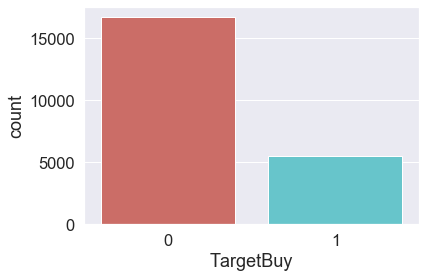

In [7]:
print("Число купивших -", len(dataframe[dataframe['TargetBuy'] == 1]))
print("Число не купивших -", len(dataframe[dataframe['TargetBuy'] == 0]))

sns.set(font_scale=1.5)
count_plt = sns.countplot(x='TargetBuy', data=dataframe, palette='hls')
plt.show()

Смотрим балансировку выборки по переменной TargetBuy. Если органический продукт приобретен - 1, если нет - 0. Вычисляем процент купивших органические продукты

In [8]:
Count_Buy = len(dataframe[dataframe["TargetBuy"]==1]) 
Count_Not_Buy = len(dataframe[dataframe["TargetBuy"]==0])
Perc_Of_Buy = Count_Buy/(Count_Buy+Count_Not_Buy)
print("Процент купивших:",Perc_Of_Buy*100)
Perc_Of_Not_Buy = Count_Not_Buy/(Count_Buy+Count_Not_Buy)
print("Процент не купивших:",Perc_Of_Not_Buy*100)

Процент купивших: 24.771632992845248
Процент не купивших: 75.22836700715474


Таким оборазом, исходя из результата, делаем вывод, что наша выборка несбалансирована. Процент некупивших намного превосходит число купивших. Построенный на таких наборах данных классификатор может оказаться абсолютно неэффективным.

Строим таблицу корреляции. Берем значение корреляции по модулю. Выбираем признаки сo значением корреляции >=0,05

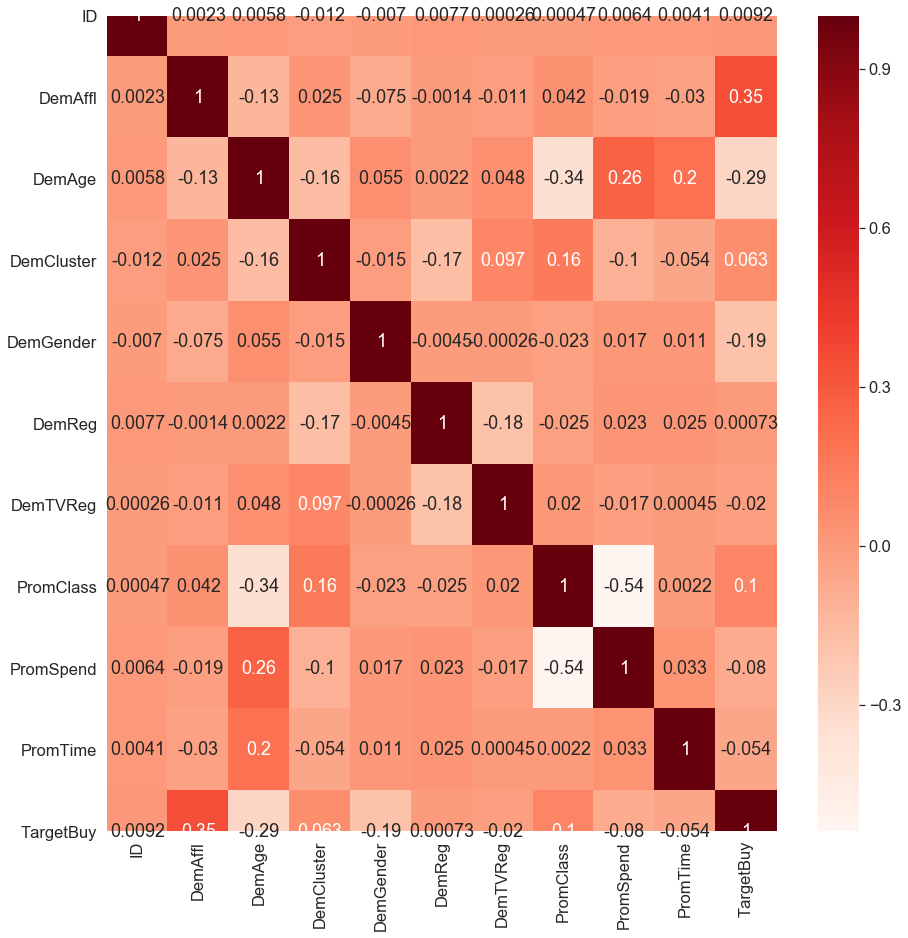

DemAffl       0.349522
DemAge        0.291768
DemCluster    0.063154
DemGender     0.186090
PromClass     0.103645
PromSpend     0.079920
PromTime      0.053880
Name: TargetBuy, dtype: float64


In [9]:
plt.figure(figsize=(15, 15))
correlation_matrix = dataframe.corr()  
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(correlation_matrix['TargetBuy'])
relevant_features = cor_target[cor_target >= 0.05].drop('TargetBuy')
print(relevant_features)

Коэффициент корреляции Пирсона показывает, что есть зависимость между DemAffl/DemAge/DemGender и TargetBuy, а переменные DemReg, DemTVReg не влияют на TargetBuy - удалим эти столбцы.

In [10]:
dataframe = dataframe.drop(columns=['DemTVReg', 'DemReg', 'ID'])

In [11]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 8 columns):
DemAffl       22223 non-null float64
DemAge        22223 non-null float64
DemCluster    22223 non-null float64
DemGender     22223 non-null int32
PromClass     22223 non-null int32
PromSpend     22223 non-null float64
PromTime      22223 non-null float64
TargetBuy     22223 non-null int64
dtypes: float64(5), int32(2), int64(1)
memory usage: 1.2 MB


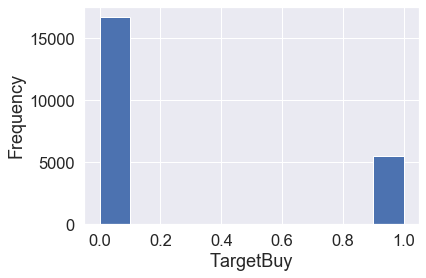

Купили/не купили товар


In [12]:
ax = dataframe['TargetBuy'].plot(kind='hist')
ax.set_xlabel('TargetBuy')
plt.show()
print("Купили/не купили товар")

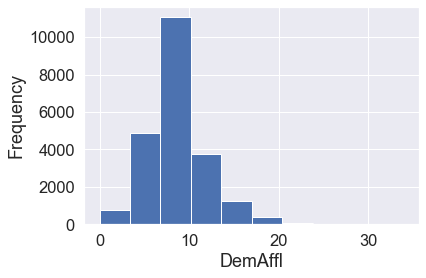

Уровень доходов


In [13]:
ax = dataframe['DemAffl'].plot(kind='hist')
ax.set_xlabel('DemAffl')
plt.show()
print("Уровень доходов")

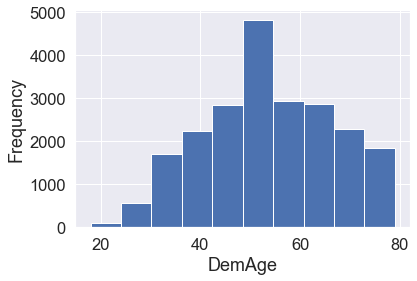

Возраст


In [14]:
ax = dataframe['DemAge'].plot(kind='hist')
ax.set_xlabel('DemAge')
plt.show()
print("Возраст")

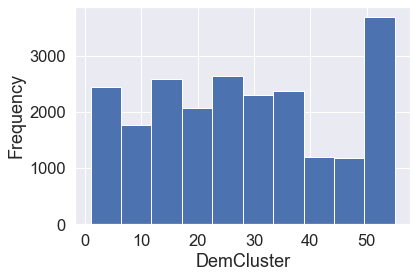

Тип района, в котором проживает клиент


In [15]:
ax = dataframe['DemCluster'].plot(kind='hist')
ax.set_xlabel('DemCluster')
plt.show()
print("Тип района, в котором проживает клиент")

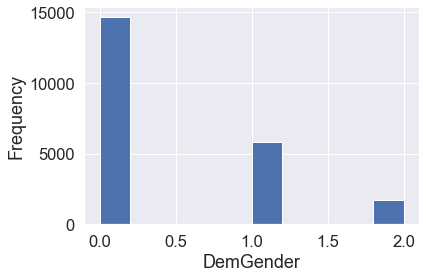

Пол


In [16]:
ax = dataframe['DemGender'].plot(kind='hist')
ax.set_xlabel('DemGender')
plt.show()
print("Пол")

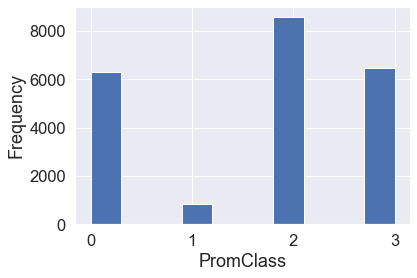

Статус программы лояльности


In [17]:
ax = dataframe['PromClass'].plot(kind='hist')
ax.set_xlabel('PromClass')
plt.show()
print("Статус программы лояльности")

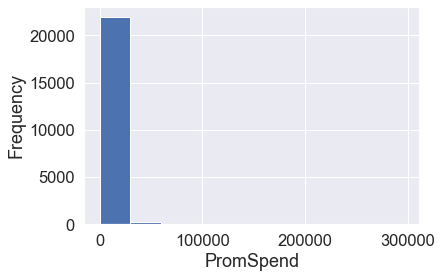

Общая потраченная сумма


In [18]:
ax = dataframe['PromSpend'].plot(kind='hist')
ax.set_xlabel('PromSpend')
plt.show()
print("Общая потраченная сумма")

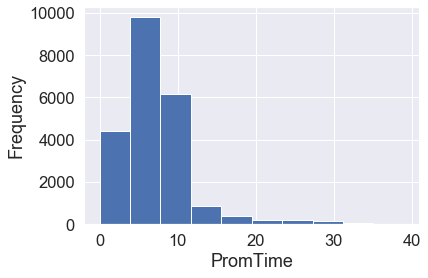

Срок участия в программе лояльности


In [19]:
ax = dataframe['PromTime'].plot(kind='hist')
ax.set_xlabel('PromTime')
plt.show()
print("Срок участия в программе лояльности")

In [20]:
def oversampling_df_by_Minority(df):
    # balance our df by Minority sample
    df_majority = df[df['TargetBuy'] == 0]
    df_minority = df[df['TargetBuy'] == 1]

    df_minority_oversampled = resample(df_minority,
                                       replace=True,
                                       n_samples=len(df_majority),
                                       random_state=4
                                       )

    df_oversampled = pd.concat([df_majority, df_minority_oversampled])
    print(df_oversampled['TargetBuy'].value_counts())

    X_res, y_res = making_X_y_from_df(df_oversampled)

    return X_res, y_res

def oversampling_df_by_SMOTE(df):
    X, y = making_X_y_from_df(df)

    print_res_sampling(X, y, 'Before', 'Oversampling')

    sm = SMOTE(random_state = 0)
    X_res, y_res = sm.fit_sample(X, y.ravel())

    print_res_sampling(X_res, y_res, 'After', 'Oversampling')

    return X_res, y_res

def oversampling_df_by_ADASYN(df):
    X, y = making_X_y_from_df(df)

    print_res_sampling(X, y, 'Before', 'Oversampling')

    ad = ADASYN(random_state = 0)
    X_res, y_res = ad.fit_sample(X, y.ravel())

    print_res_sampling(X_res, y_res, 'After', 'Oversampling')

    return X_res, y_res

def undersampling_df(df):
    dfBuy = df.loc[df["TargetBuy"] == 1]
    dfNotBuy = df.loc[df["TargetBuy"] == 0].sample(n=5505,random_state=42)

    undersampled_df = pd.concat([dfBuy, dfNotBuy])

    print("\nAfter undersampling amount:")
    print(dfBuy.shape[0])
    print(dfNotBuy.shape[0])

    X_res, y_res = making_X_y_from_df(df)

    return X_res, y_res

def undersampling_df_NearMiss(df):
    X, y = making_X_y_from_df(df)

    print_res_sampling(X, y, 'Before', 'Undersampling')

    # apply near miss
    nr = NearMiss()

    X_res, y_res = nr.fit_sample(X, y.ravel())

    print_res_sampling(X_res, y_res, 'After', 'Undersampling')

    return X_res, y_res


In [21]:
def plot_roc_curve(fpr, tpr, n, current_score):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with AUC score - %.4f' % current_score)
    # plt.annotate()
    plt.legend()
    plt.savefig('C:/Users/Almaz/Desktop/SAS/Balance/' + str(n) + '.png', bbox_inches='tight')
    plt.close()


def plot_score_graphic(x_array, y_array, filename):
    fig = plt.figure(figsize=(25, 11), dpi=100)
    plt.plot(x_array, y_array, 'bo-')

    for i, j in zip(x_array, y_array):
        label = "{0:.3f}".format(j)

        plt.annotate(label,
                     xy=(i, j),
                     xytext=(0, 10),
                     textcoords="offset points",
                     ha='center'
                     )

    plt.savefig(filename,
                bbox_inches='tight',
                dpi=100)
    plt.close(fig)

def create_png_image_for_extended_tree(treeEnt, fileDot, filePng, names):
    export_graphviz(treeEnt, out_file=fileDot,
                    rounded=True, proportion=False,
                    precision=3, filled=True,
                    class_names=True,
                    feature_names=names
                    )

    (graph,) = pydot.graph_from_dot_file(fileDot)

    graph.write_png(filePng)

    return 1

In [22]:
def making_X_y_from_df(df):
    X_res = df
    X_res= X_res.drop(columns=['TargetBuy'])
    y_res = df['TargetBuy']
    y_res = y_res.astype('int')

    return X_res, y_res

def train_test_splitting(X_res, y_res):
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3)

    return X_train, X_test, y_train, y_test

def print_res_sampling(X, y, status, method_name):
    if(status == 'Before'):
        print(status + " " + method_name + ", counts of label '1': {}".format(sum(y == 1)))
        print(status + " " + method_name + ", counts of label '0': {} \n".format(sum(y == 0)))
    else:
        print(status + " " + method_name + ", the shape of train_X: {}".format(X.shape))
        print(status + " " + method_name + ", the shape of train_y: {} \n".format(y.shape))
        print(status + " " + method_name + ", counts of label '1': {}".format(sum(y == 1)))
        print(status + " " + method_name + ", counts of label '0': {}".format(sum(y == 0)))

In [23]:
X_res_Minority, y_res_Minority = oversampling_df_by_Minority(dataframe)

X_train_Minority, X_test_Minority, y_train_Minority, y_test_Minority = train_test_splitting(X_res_Minority, y_res_Minority)

max_depth_values = range(1, 45)

scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, min_samples_leaf = 1, random_state=0)
    clf.fit(X_train_Minority, y_train_Minority)
    train_score = clf.score(X_train_Minority, y_train_Minority)
    test_score = clf.score(X_test_Minority, y_test_Minority)

    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': test_score})
    scores_data = scores_data.append(temp_score_data)

scores_data.head(45)

1    16718
0    16718
Name: TargetBuy, dtype: int64


,max_depth,train_score,test_score
0,1,0.682504,0.674708
0,2,0.716086,0.715582
0,3,0.720487,0.716678
0,4,0.731040,0.728143
0,5,0.733390,0.731732
0,6,0.736766,0.730934
0,7,0.744200,0.736816
0,8,0.749797,0.735919
0,9,0.757915,0.740804
0,10,0.768767,0.738610


In [24]:
X_res_SMOTE, y_res_SMOTE = oversampling_df_by_SMOTE(dataframe)

X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_splitting(X_res_SMOTE, y_res_SMOTE)

max_depth_values = range(1, 20)

scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, min_samples_leaf = 1, random_state=0)
    clf.fit(X_train_SMOTE, y_train_SMOTE)
    train_score = clf.score(X_train_SMOTE, y_train_SMOTE)
    test_score = clf.score(X_test_SMOTE, y_test_SMOTE)

    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': test_score})
    scores_data = scores_data.append(temp_score_data)

scores_data.head(20)

Before Oversampling, counts of label '1': 5505
Before Oversampling, counts of label '0': 16718 

After Oversampling, the shape of train_X: (33436, 7)
After Oversampling, the shape of train_y: (33436,) 

After Oversampling, counts of label '1': 16718
After Oversampling, counts of label '0': 16718


,max_depth,train_score,test_score
0,1,0.682076,0.679294
0,2,0.701004,0.700329
0,3,0.754582,0.751670
0,4,0.756975,0.748878
0,5,0.783721,0.782674
0,6,0.786413,0.782574
0,7,0.811066,0.807696
0,8,0.815168,0.808892
0,9,0.841572,0.824544
0,10,0.848665,0.827634


In [25]:
balance_NearMiss = undersampling_df_NearMiss(dataframe)

Before Undersampling, counts of label '1': 5505
Before Undersampling, counts of label '0': 16718 

After Undersampling, the shape of train_X: (11010, 7)
After Undersampling, the shape of train_y: (11010,) 

After Undersampling, counts of label '1': 5505
After Undersampling, counts of label '0': 5505


In [26]:
balance_under = undersampling_df(dataframe)


After undersampling amount:
5505
5505


In [27]:
X_res_ADASYN, y_res_ADASYN = oversampling_df_by_ADASYN(dataframe)

X_train_ADASYN, X_test_ADASYN, y_train_ADASYN, y_test_ADASYN = train_test_splitting(X_res_ADASYN, y_res_ADASYN)

max_depth_values = range(1, 20)

scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, min_samples_leaf = 1, random_state=0)
    clf.fit(X_train_ADASYN, y_train_ADASYN)
    train_score = clf.score(X_train_ADASYN, y_train_ADASYN)
    test_score = clf.score(X_test_ADASYN, y_test_ADASYN)

    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': test_score})
    scores_data = scores_data.append(temp_score_data)

scores_data.head(20)

Before Oversampling, counts of label '1': 5505
Before Oversampling, counts of label '0': 16718 

After Oversampling, the shape of train_X: (33600, 7)
After Oversampling, the shape of train_y: (33600,) 

After Oversampling, counts of label '1': 16882
After Oversampling, counts of label '0': 16718


,max_depth,train_score,test_score
0,1,0.642645,0.650794
0,2,0.699660,0.706944
0,3,0.737330,0.744048
0,4,0.754124,0.757440
0,5,0.767645,0.769742
0,6,0.781420,0.781647
0,7,0.799872,0.799603
0,8,0.805060,0.807937
0,9,0.831378,0.826984
0,10,0.838180,0.832143
